In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import keras

if keras.backend.backend() == "torch":
    import torch
    print("Use torch backend")
    torch.autograd.set_grad_enabled(False)

import sys

current_dir = globals()['_dh'][0]
sys.path.append(os.path.join(current_dir, "../"))

import bayesflow as bf

import numpy as np

from custom_simulators import ParameterMask, RandomNumObs
from design_networks import RandomDesign, DeepAdaptiveDesign, EncoderNetwork
from design_networks_old import EmitterNetwork
from custom_dataset import DataSet
from experiment_1 import PolynomialRegression, PriorPolynomialReg
from diagnostics import plot_recovery

Use torch backend


/opt/miniconda3/envs/bayesflow/lib/python3.11/site-packages/keras/src/backend/torch/numpy.py:870: UserWarning: The operator 'aten::logspace.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1715184405838/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  torch.logspace(


Use torch backend


In [ ]:
arguments = {""}

In [2]:
bf_summary_dim = 10
T = 5
scaler = 5
noise_size = 1.0
dad_encoder_hidden_dim = 32
dad_summary_dim = 10
dad_emitter_hidden_dim = 2
bf_batch_size = 128
min_design = -5
max_design = 5

inference_network = bf.networks.FlowMatching() # bf.networks.CouplingFlow()
summary_network = bf.networks.DeepSet(summary_dim = bf_summary_dim)

approximator = bf.Approximator(
    inference_network = inference_network,
    summary_network = summary_network,
    inference_variables = ["params"],
    inference_conditions = ["masks", "n_obs"],
    summary_variables = ["outcomes", "designs"]
)

design_shape = torch.Size([1])
mask_sampler = ParameterMask()
prior_sampler = PriorPolynomialReg()
random_num_obs_1 = RandomNumObs(min_obs = 1, max_obs = T)
random_num_obs_2 = RandomNumObs(min_obs = 0, max_obs = T)

random_design_generator = RandomDesign(design_shape = design_shape, min = min_design, max = max_design)

model_1 = PolynomialRegression(mask_sampler = mask_sampler,
                                        prior_sampler = prior_sampler,
                                        tau_sampler = random_num_obs_1,
                                        design_generator = random_design_generator,
                                        sim_vars = {"sigma": noise_size})

encoder_net = EncoderNetwork(xi_dim = 1, y_dim = 1, hidden_dim = dad_encoder_hidden_dim, encoding_dim = dad_summary_dim)
decoder_net = EmitterNetwork(input_dim = dad_summary_dim, hidden_dim = dad_emitter_hidden_dim, output_dim = 1) # [B, summary_dim] -> [B, xi_dim]
design_net = DeepAdaptiveDesign(encoder_net = encoder_net,
                                decoder_net = decoder_net,
                                design_shape = design_shape, 
                                summary_variables=["outcomes", "designs"])

In [72]:
mask = [[1., 1., 1., 1.]]
n_sims = 2000; n_post_samples = 100

# evaluate recovery and shannon entropy using same prior draws
prior_samples = prior_sampler.sample(masks = torch.tensor(mask).repeat(n_sims, 1))
prior_single_sample = prior_samples[0].unsqueeze(0)

## Random policy (only bayesflow)

In [73]:
# load stage 1 bf weights

PATH = "results/" + "dad_second_t_5"
# load weight of the design network
path_design_approximator = PATH + "/design_network.pt"
state_dict = torch.load(path_design_approximator)["model_state_dict"]
design_net.load_state_dict(state_dict)

model_2 = PolynomialRegression(mask_sampler = mask_sampler,
                                        prior_sampler = prior_sampler,
                                        tau_sampler = random_num_obs_2,
                                        design_generator = design_net,
                                        sim_vars = {"sigma": noise_size}) # for design

    
model_3 = PolynomialRegression(mask_sampler = mask_sampler,
                                        prior_sampler = prior_sampler,
                                        tau_sampler = random_num_obs_1,
                                        design_generator = design_net,
                                        sim_vars = {"sigma": noise_size})

batch_shape_b = torch.Size([bf_batch_size])
# batch_shape_d = torch.Size([dad_positive_samples])

dataset = DataSet(batch_shape = batch_shape_b, 
                    joint_model_1 = model_1,
                    joint_model_2 = model_2,
                    joint_model_3 = model_3)
dataset.set_stage(1)
approximator.build_from_data(dataset.__getitem__(0))
path_bf_weights_s1 = PATH + "/approximator_stage_1.weights.h5"
approximator_1 = approximator
approximator_1.load_weights(path_bf_weights_s1)
test_sims = model_1.sample(torch.Size([n_sims]), tau = torch.tensor([T]), masks = torch.tensor(mask))
post_samples = approximator_1.sample((n_sims, n_post_samples), data = test_sims)["params"].to('cpu').numpy()

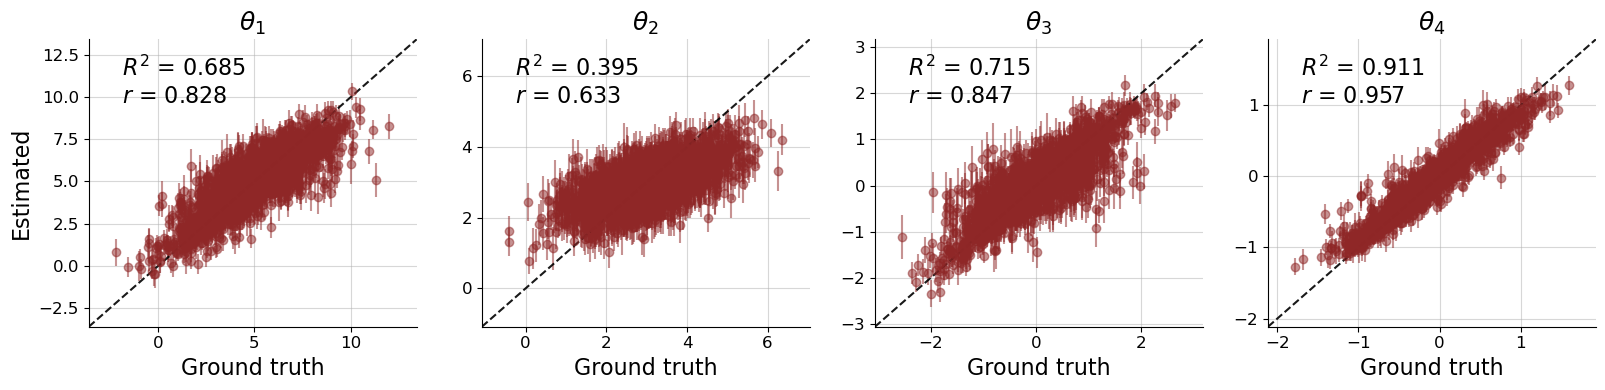

In [74]:
n_sims = 2000; n_post_samples = 100
test_sims = model_1.sample(torch.Size([n_sims]), tau = torch.tensor([T]), masks = torch.tensor(mask), params = prior_samples)
post_samples = approximator_1.sample((n_sims, n_post_samples), data = test_sims)["params"].to('cpu').numpy()
f = plot_recovery(post_samples, test_sims["params"].numpy(), point_agg = np.mean)

In [67]:
num_grid = 10
grid_1 = np.linspace(-2, 12, num_grid)
grid_2 = np.linspace(0, 6, num_grid)
grid_3 = np.linspace(-3, 3, num_grid)
grid_4 = np.linspace(-2, 2, num_grid)
param_1, param_2, param_3, param_4 = np.meshgrid(grid_1, grid_2, grid_3, grid_4)
params = np.c_[param_1.flatten(), param_2.flatten(), param_3.flatten(), param_4.flatten()].astype(np.float32)

In [68]:
# shannon_entropy
test_sim_single = model_1.sample(torch.Size([1]), tau = torch.tensor([T]), params = prior_single_sample)
test_sim_single_rep = {}
test_sim_single_rep["params"] = params
test_sim_single_rep["masks"] = test_sim_single["masks"].numpy().repeat(num_grid**4, 0)
test_sim_single_rep["n_obs"] = test_sim_single["n_obs"].numpy().repeat(num_grid**4, 0)
test_sim_single_rep["outcomes"] = test_sim_single["outcomes"].numpy().repeat(num_grid**4, 0)
test_sim_single_rep["designs"] = test_sim_single["designs"].numpy().repeat(num_grid**4, 0)
lpdf = approximator.log_prob(test_sim_single_rep)
shannon_entropy = -torch.sum(torch.exp(lpdf) * lpdf).to('cpu').numpy()
print(shannon_entropy)

-1.5167116


## DAD second

In [75]:
# load stage 3 bf weights
dataset.set_stage(3)
approximator_2 = approximator
approximator_2.build_from_data(dataset.__getitem__(0))
path_bf_weights_s3 = PATH + "/approximator.weights.h5"
approximator_2.load_weights(path_bf_weights_s3)
n_sims = 2000; n_post_samples = 100
test_sims = model_2.sample(torch.Size([n_sims]), tau = torch.tensor([T]), masks = torch.tensor(mask), params = prior_samples)
post_samples = approximator_2.sample((n_sims, n_post_samples), data = test_sims)["params"].to('cpu').numpy()

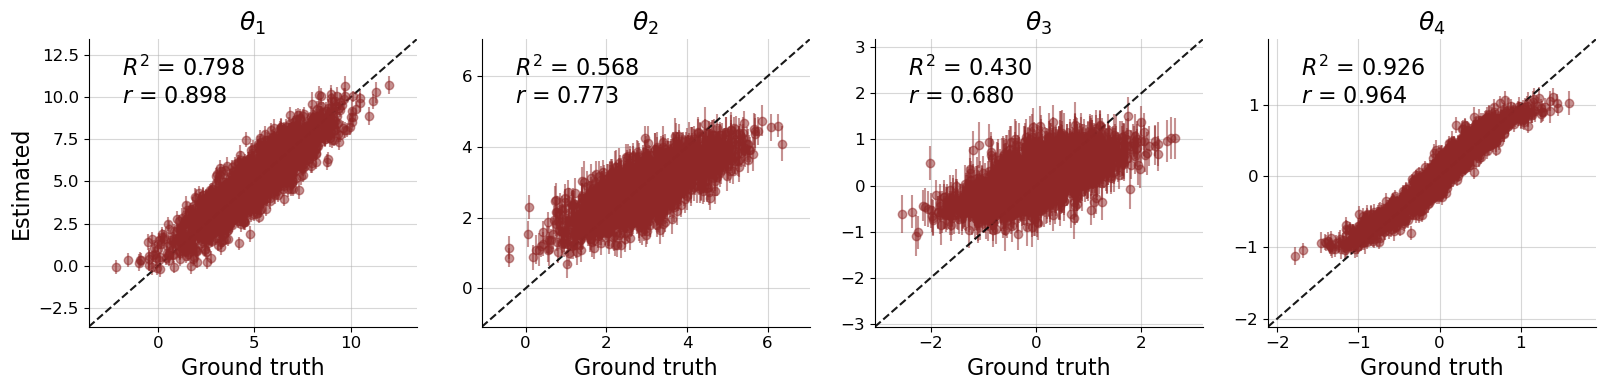

In [76]:
f = plot_recovery(post_samples, test_sims["params"].numpy(), point_agg = np.mean)

In [77]:
# shannon entropy
test_sim_single = model_2.sample(torch.Size([1]), tau = torch.tensor([T]), masks = torch.tensor(mask), params = prior_single_sample)
test_sim_single_rep = {}
test_sim_single_rep["params"] = params
test_sim_single_rep["masks"] = test_sim_single["masks"].numpy().repeat(num_grid**4, 0)
test_sim_single_rep["n_obs"] = test_sim_single["n_obs"].numpy().repeat(num_grid**4, 0)
test_sim_single_rep["outcomes"] = test_sim_single["outcomes"].numpy().repeat(num_grid**4, 0)
test_sim_single_rep["designs"] = test_sim_single["designs"].numpy().repeat(num_grid**4, 0)
lpdf = approximator_2.log_prob(test_sim_single_rep)
shannon_entropy = -torch.sum(torch.exp(lpdf) * lpdf).to('cpu').numpy()
print(shannon_entropy)

2.0972161


## DAD only

In [78]:
PATH = "results/" + "dad_first_t_5"

In [79]:
# load stage 2 bf weights and sample from posterior
path_design_approximator = PATH + "/design_network_stage_1.pt"
state_dict = torch.load(path_design_approximator)["model_state_dict"]
design_net.load_state_dict(state_dict)

model_2 = PolynomialRegression(mask_sampler = mask_sampler,
                                        prior_sampler = prior_sampler,
                                        tau_sampler = random_num_obs_2,
                                        design_generator = design_net,
                                        sim_vars = {"sigma": noise_size})

    
model_3 = PolynomialRegression(mask_sampler = mask_sampler,
                                        prior_sampler = prior_sampler,
                                        tau_sampler = random_num_obs_1,
                                        design_generator = design_net,
                                        sim_vars = {"sigma": noise_size})

batch_shape_b = torch.Size([bf_batch_size])
# batch_shape_d = torch.Size([dad_positive_samples])

dataset = DataSet(batch_shape = batch_shape_b, 
                    joint_model_1 = model_1,
                    joint_model_2 = model_2,
                    joint_model_3 = model_3)

dataset.set_stage(3)
approximator_3 = approximator
approximator_3.build_from_data(dataset.__getitem__(0))
path_bf_weights_s2 = PATH + "/approximator_stage_2.weights.h5"
approximator_3.load_weights(path_bf_weights_s2)
test_sims = model_2.sample(torch.Size([n_sims]), tau = torch.tensor([T]), masks = torch.tensor(mask), params = prior_samples)
post_samples = approximator_3.sample((n_sims, n_post_samples), data = test_sims)["params"].to('cpu').numpy()

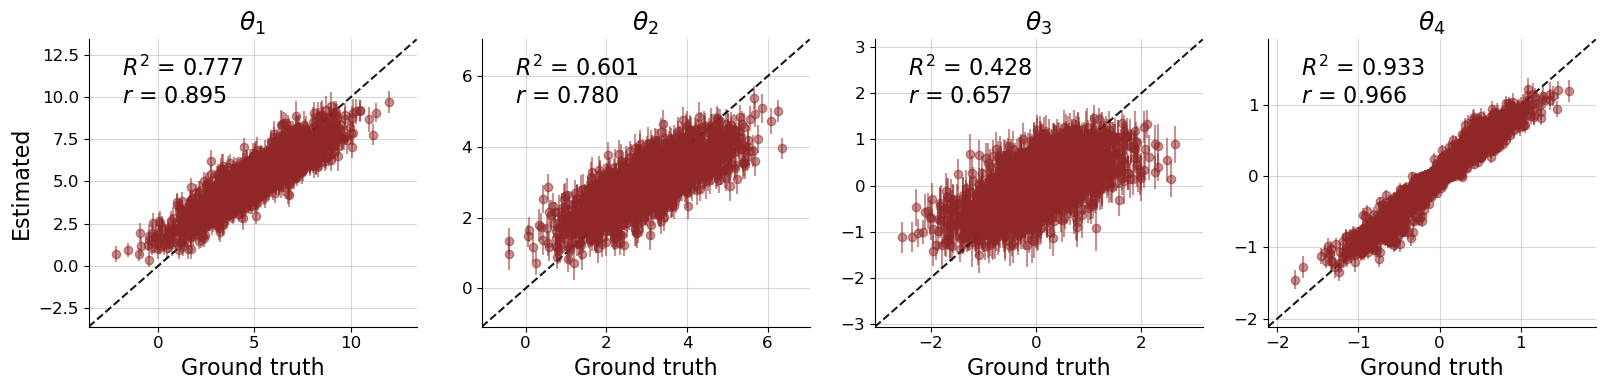

In [80]:
f = plot_recovery(post_samples, test_sims["params"].numpy(), point_agg = np.mean)

In [171]:
# shannon entropy
test_sim_single = model_2.sample(torch.Size([1]), tau = torch.tensor([T]), masks = torch.tensor(mask), params = prior_single_sample)
test_sim_single_rep = {}
test_sim_single_rep["params"] = params
test_sim_single_rep["masks"] = test_sim_single["masks"].numpy().repeat(num_grid**4, 0)
test_sim_single_rep["n_obs"] = test_sim_single["n_obs"].numpy().repeat(num_grid**4, 0)
test_sim_single_rep["outcomes"] = test_sim_single["outcomes"].numpy().repeat(num_grid**4, 0)
test_sim_single_rep["designs"] = test_sim_single["designs"].numpy().repeat(num_grid**4, 0)
lpdf = approximator_3.log_prob(test_sim_single_rep)
shannon_entropy = -torch.sum(torch.exp(lpdf) * lpdf).to('cpu').numpy()
print(shannon_entropy)

7.322734


## DAD-second n_hist = 8

I somehow set hidden dim to be 256 here so it's not really fair comparison

In [185]:
# load stage 1 bf weights
encoder_net = EncoderNetwork(xi_dim = 1, y_dim = 1, hidden_dim = 256, encoding_dim = dad_summary_dim)

design_net = DeepAdaptiveDesign(encoder_net = encoder_net,
                                decoder_net = decoder_net,
                                design_shape = design_shape, 
                                summary_variables=["outcomes", "designs"])

PATH = "results/" + "dad_second_t_5_hist_8"
# load weight of the design network
path_design_approximator = PATH + "/design_network.pt"

state_dict = torch.load(path_design_approximator)["model_state_dict"]
design_net.load_state_dict(state_dict)

model_2 = PolynomialRegression(mask_sampler = mask_sampler,
                                        prior_sampler = prior_sampler,
                                        tau_sampler = random_num_obs_2,
                                        design_generator = design_net,
                                        sim_vars = {"sigma": noise_size}) # for design

    
model_3 = PolynomialRegression(mask_sampler = mask_sampler,
                                        prior_sampler = prior_sampler,
                                        tau_sampler = random_num_obs_1,
                                        design_generator = design_net,
                                        sim_vars = {"sigma": noise_size})

batch_shape_b = torch.Size([bf_batch_size])
# batch_shape_d = torch.Size([dad_positive_samples])

dataset = DataSet(batch_shape = batch_shape_b, 
                    joint_model_1 = model_1,
                    joint_model_2 = model_2,
                    joint_model_3 = model_3)
dataset.set_stage(3)
approximator_4 = approximator
approximator_4.build_from_data(dataset.__getitem__(0))
path_bf_weights_s3 = PATH + "/approximator.weights.h5"
approximator_4.load_weights(path_bf_weights_s3)
n_sims = 2000; n_post_samples = 100
test_sims = model_2.sample(torch.Size([n_sims]), tau = torch.tensor([T]), masks = torch.tensor(mask), params = prior_samples)
post_samples = approximator_4.sample((n_sims, n_post_samples), data = test_sims)["params"].to('cpu').numpy()

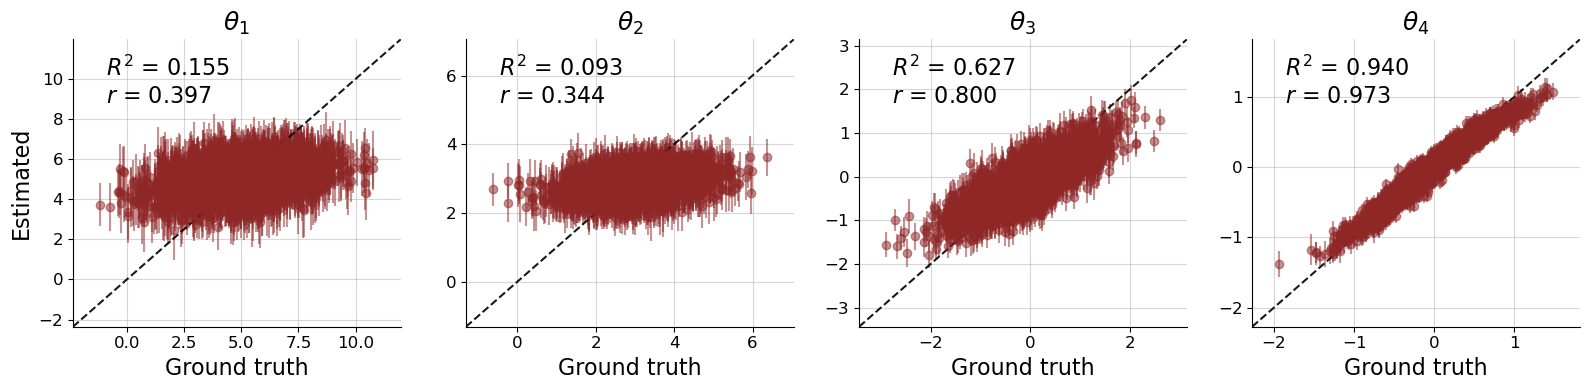

In [186]:
f = plot_recovery(post_samples, test_sims["params"].numpy(), point_agg = np.mean)